In [1]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import io

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(torch.__version__)

2.1.0


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Hyperparameters
IN_CHANNEL = 3
NUM_CLASSES = 5
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 1e-3

# 1.Dataset

 kaggle : https://www.kaggle.com/datasets/antobenedetti/animals

In [4]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B1_Weights.IMAGENET1K_V2

In [5]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [6]:
train_transform = transforms.Compose([
    #transforms.CenterCrop(224),
    transforms.Resize((256,256)),
    transforms.RandomRotation(degrees=(0, 180)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])    
])

val_transform = transforms.Compose([
    #transforms.CenterCrop(224),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [7]:
class Dataset(Dataset):
    def __init__(self,root_dir,transforms = None):
        self.data = ImageFolder(root_dir,transform=transforms)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx]

In [8]:
train_path = '../../Kaggle_Dataset/MultiClass_Classification/Animals/train/'
val_path = '../../Kaggle_Dataset/MultiClass_Classification/Animals/val/'


train_dataset = Dataset(train_path,train_transform)
val_dataset = Dataset(val_path,val_transform)

In [9]:
len(train_dataset),len(val_dataset)

(13474, 1497)

In [10]:
class_names = ImageFolder(train_path).classes
class_names

['cat', 'dog', 'elephant', 'horse', 'lion']

In [11]:
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [12]:
image , label = next(iter(train_dataloader))
image.shape , label.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

# 2.Model

In [13]:
model = torchvision.models.efficientnet_b1(weights=weights).to(device)

In [14]:
from torchinfo import summary
summary(model, input_size=[32, 3, 240, 240],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 240, 240]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

In [15]:
for param in model.features.parameters():
    param.requires_grad = False

In [16]:
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=NUM_CLASSES, # same number of output units as our number of classes
                    bias=True)).to(device)

In [17]:
'''
model.fc = torch.nn.Linear(in_features=512, 
                    out_features=NUM_CLASSES, # same number of output units as our number of classes
                    bias=True).to(device)
'''

'\nmodel.fc = torch.nn.Linear(in_features=512, \n                    out_features=NUM_CLASSES, # same number of output units as our number of classes\n                    bias=True).to(device)\n'

In [18]:
from torchinfo import summary
summary(model, input_size=[32, 3, 240, 240],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 240, 240]    [32, 5]              --                   Partial
├─Sequential (features)                                      [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 

# 3.Loss & optimizer

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

# 4.Train & Val

In [20]:
from train_test import train

In [21]:
model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1  | train_loss: 0.6193 | test_loss: 0.2806 | 
Epoch: 2  | train_loss: 0.3446 | test_loss: 0.2016 | 
Epoch: 3  | train_loss: 0.2936 | test_loss: 0.1696 | 
Epoch: 4  | train_loss: 0.2786 | test_loss: 0.1653 | 
Epoch: 5  | train_loss: 0.2665 | test_loss: 0.1503 | 
Epoch: 6  | train_loss: 0.2569 | test_loss: 0.1449 | 
Epoch: 7  | train_loss: 0.2501 | test_loss: 0.1387 | 
Epoch: 8  | train_loss: 0.2473 | test_loss: 0.1391 | 
Epoch: 9  | train_loss: 0.2425 | test_loss: 0.1267 | 
Epoch: 10  | train_loss: 0.2369 | test_loss: 0.1246 | 
Epoch: 11  | train_loss: 0.2423 | test_loss: 0.1252 | 
Epoch: 12  | train_loss: 0.2485 | test_loss: 0.1263 | 
Epoch: 13  | train_loss: 0.2346 | test_loss: 0.1298 | 
Epoch: 14  | train_loss: 0.2296 | test_loss: 0.1224 | 
Epoch: 15  | train_loss: 0.2336 | test_loss: 0.1155 | 


# 5.Plot Loss Curve

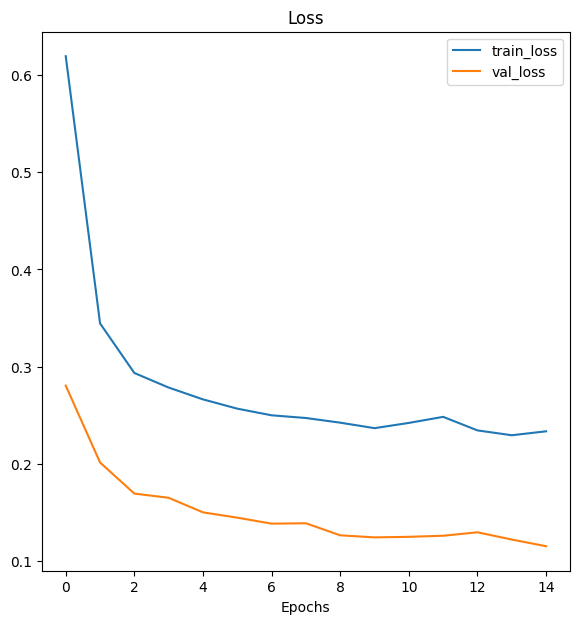

In [22]:
from loss_acc_curves import plot_loss_curves
plot_loss_curves(model_0_results)

# 6.Saving & Loading

In [32]:
MODEL_PATH = 'models'
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
# Create model save path 
MODEL_NAME = "model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH + '/' + MODEL_NAME

# Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/model_2.pth


In [33]:
loaded_model = torchvision.models.efficientnet_b1().to(device)

loaded_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=NUM_CLASSES, # same number of output units as our number of classes
                    bias=True)).to(device)

loaded_model.load_state_dict(torch.load('models/model_2.pth'))

<All keys matched successfully>

# 7.Evaluate

In [34]:
def test(model,image_path: str, 
               transform=None,
               device: torch.device = device):
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    if transform:
        target_image = transform(target_image)
        
    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)
        y_logits = model(target_image.to(device))
        print(f"logits : {y_logits.cpu().numpy().squeeze()}\n")
        target_image_pred_probs = torch.softmax(y_logits,dim=1)
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
        
    #predictions = torch.FloatTensor(target_image_pred_label)
    return target_image_pred_label,target_image_pred_probs

In [35]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.CenterCrop(224),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [36]:
test_path = '../../Kaggle_Dataset/MultiClass_Classification/Animals/inf/'

import os
from os import listdir
y_list = []
pred_list = []
for images in os.listdir(test_path):
    # check if the image ends with jpg
    if (images.endswith(".jpg")):
        image_path = os.path.join(test_path,images)
        image_index = class_names.index(images.split('.')[0]) #extract name from .jpg then extract index of class
        y_list.append(image_index)
        y_pred,y_prob = test(loaded_model,image_path,test_transform,device)
        pred_list.append(y_pred.item())
        print(f"actual : {image_index} | pred : {y_pred.max()} | prob : {y_prob.max():.3f}\n")
print(f"actual : {y_list}")
print(f"prediction : {pred_list}")

logits : [ 6.9009266 -0.9760988 -1.342401  -2.9951766  1.8081201]

actual : 0 | pred : 0 | prob : 0.993

logits : [-1.7861862   1.6324575   0.66361696  1.4620156   0.43374574]

actual : 1 | pred : 1 | prob : 0.391

logits : [-3.473604  -2.8424323  5.3485937 -0.6679668  0.6446758]

actual : 2 | pred : 2 | prob : 0.988

logits : [-1.5476799  -1.0708216   0.06771226  5.753822   -1.5628331 ]

actual : 3 | pred : 3 | prob : 0.994

logits : [-0.52600604  0.4996074  -1.0300311  -1.2289157   7.6385055 ]

actual : 4 | pred : 4 | prob : 0.999

actual : [0, 1, 2, 3, 4]
prediction : [0, 1, 2, 3, 4]


In [37]:
custom_image_path = '../../Kaggle_Dataset/MultiClass_Classification/Animals/inf/cat.jpg'
target_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
target_image = test_transform(target_image)
target_image.shape

torch.Size([3, 256, 256])

In [38]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names= None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    #target_image = io.imread(image_path)
    #target_image = cv2.imread(image_path)
    #rgb_image = cv2.cvtColor(target_image,cv2.COLOR_BGR2RGB)
    #plt.imshow(rgb_image.squeeze())
    #target_image = target_image.astype('float32') 

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    #target_image = image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.sigmoid() for binary-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # get key from value
    #position = value_list.index(target_image_pred_label)
    #print(key_list[position])
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow((image.squeeze().permute(1, 2, 0)).type(torch.uint8))
    #plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Class: {target_image_pred_label.max()} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {key_list[position]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

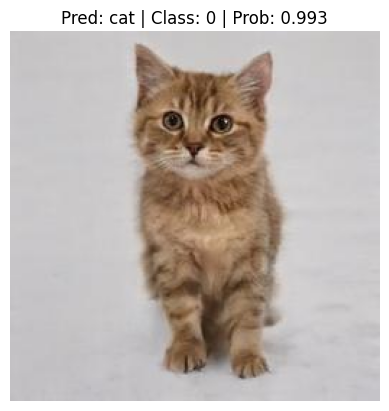

In [39]:
pred_and_plot_image(model=loaded_model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=test_transform,
                    device=device)

,precision,recall,f1-score,support
0.0,1.0,1.0,1.0,1.0
1.0,1.0,1.0,1.0,1.0
2.0,1.0,1.0,1.0,1.0
3.0,1.0,1.0,1.0,1.0
4.0,1.0,1.0,1.0,1.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,5.0
weighted avg,1.0,1.0,1.0,5.0


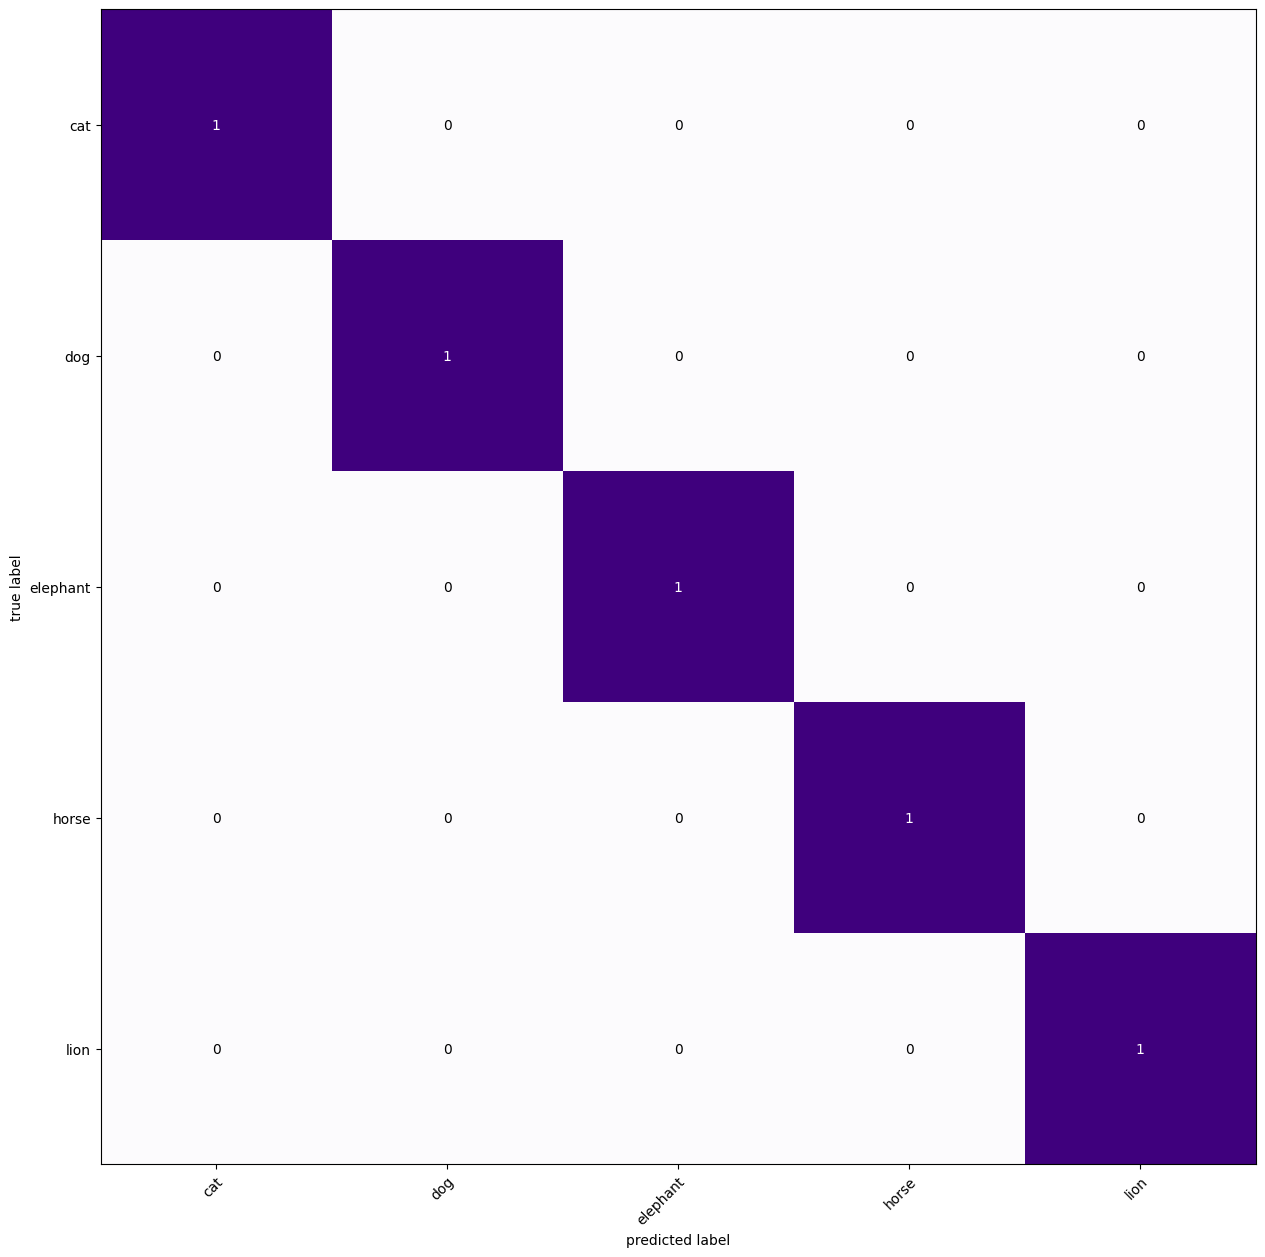

In [40]:
from confusion_matrix import confusionMatrix as cm
actual = torch.FloatTensor(y_list)
predictions = torch.FloatTensor(pred_list)
cm(actual,predictions,class_names,task='multiclass',cmap='Purples')